In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,LabelBinarizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates
from math import pi

wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
print(wine_base.columns)
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset
    
wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
#not using regional stuff
#wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)
wine_base.drop(["designation","description"],axis=1,inplace=True)

lb = LabelBinarizer()

#wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base.drop("winery",axis=1,inplace=True)
#wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base.drop("region_1",axis=1,inplace=True)
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes
wine_base

Index(['description', 'designation', 'points', 'price', 'province', 'region_1',
       'taster_name', 'title', 'variety', 'winery',
       'similarityTop3WinesByVariety', 'word_count', 'tf_grouped_1',
       'tf_grouped_2', 'tf_grouped_3', 'tfIdf_grouped_1', 'tfIdf_grouped_2',
       'tfIdf_grouped_3', 'tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',
       'tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3'],
      dtype='object')


,country,points,price,variety,similarityTop3WinesByVariety,word_count,vintage,Alexander Peartree,Anna Lee C. Iijima,Anne Krebiehl MW,...,Kerin O’Keefe,Lauren Buzzeo,Matt Kettmann,Michael Schachner,Paul Gregutt,Roger Voss,Sean P. Sullivan,Susan Kostrzewa,Virginie Boone,unknown
0,Italy,87,17.000000,597,1.142944,10,2013,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Portugal,87,15.000000,385,1.078157,6,2011,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,US,87,14.000000,373,1.156945,10,2013,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,US,87,13.000000,409,1.025862,13,2013,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,US,87,65.000000,377,1.192760,16,2012,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,Spain,87,15.000000,508,0.648527,17,2011,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Italy,87,16.000000,163,0.963839,10,2013,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,France,87,24.000000,185,1.094184,8,2012,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,Germany,87,12.000000,185,1.050787,12,2013,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,France,87,27.000000,373,1.043785,11,2012,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


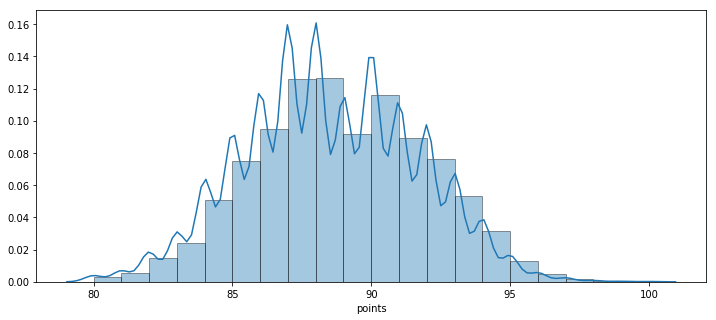

In [2]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

wine2 = pd.DataFrame()
wine2 = wine_base
nbins  = 3
labels=["low","medium","high"]
g,b = pd.qcut(wine2["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
g.tolist()
wine2["category"] = g

wine2.drop("description",axis=1,inplace=True)

parallel coordinates would be nice

low = wine2[wine2["category"] == "low"]
medium = wine2[wine2["category"] == "medium"]
high = wine2[wine2["category"] == "high"]

wine3 = pd.DataFrame()
features = ["category",'vintage', 'country', 'points', 'price', 'province','region_1', 'taster_name', 'variety', 'winery','similarityTop3WinesByVariety', 'word_count']
for feat in features:
    wine3[feat] = wine2[feat]
fig, ax = plt.subplots(figsize = (25, 10))
parallel_coordinates(wine3, 'category', colormap=plt.get_cmap("Set2"))
plt.show()

In [ ]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Points distribution for " + c)
    ax.set(xticks=wine_base["points"].unique())
    sns.distplot(temp["points"],hist=True,bins = 20,hist_kws={"width": 0.5,'edgecolor':'black'})
    sns

In [ ]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Price distribution for " + c)
    sns.distplot(temp["price"],hist=True)
    sns

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

10.0


<module 'seaborn' from 'C:\\Users\\gneur\\Anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

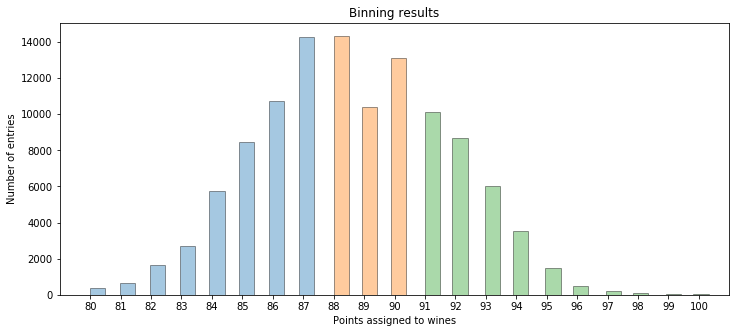

In [3]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  

#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
plt.ylabel("Number of entries")
plt.xlabel("Points assigned to wines")
plt.title("Binning results")
print(g)
sns

In [ ]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
#tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
#tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
#tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
#tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + word2vec

# test stuff based on countries

In [34]:
countries = wine_base["country"].unique().tolist()
countries
for c in countries:
    print(c,len(wine_base[wine_base["country"] == c]))
test = wine_base["country"].unique().tolist()
test

Italy 16965
Portugal 4950
US 49529
Spain 5637
France 18906
Germany 1978
Argentina 3495
Chile 4159
Australia 2130
Austria 2996
South Africa 1284
New Zealand 1268


['Italy',
 'Portugal',
 'US',
 'Spain',
 'France',
 'Germany',
 'Argentina',
 'Chile',
 'Australia',
 'Austria',
 'South Africa',
 'New Zealand']

In [33]:
def testByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest(wine3,el)
        df = df.append(res)
    return df

def applyTest(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] != objCountry]
        y_train = pd.DataFrame()
        #obbiettivo è la categoria del dataframe X_train perchè è quello che contiene le righe giuste per le country
        y_train = list(X_train["category"])
        print(objCountry +" must not be in training set " + str(X_train["country"].unique().tolist()))
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] == objCountry]
        y_test = X_test["category"]
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [35]:
basic = ["price",'vintage', 'province', 'region_1', 'taster_name', 'variety','winery'] #country non deve esserci 
word = ["word_count"]
word2vec = ['similarityTop3WinesByVariety']
features = []
for el in wine_base.columns:
    if el != "description":
        features.append(el)

result = testByCountry(wine_base,countries)
len(result.columns.tolist())
result.drop("input",inplace=True,axis=1)
result

Italy must not be in training set ['Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Portugal must not be in training set ['Italy', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
US must not be in training set ['Italy', 'Portugal', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Spain must not be in training set ['Italy', 'Portugal', 'US', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
France must not be in training set ['Italy', 'Portugal', 'US', 'Spain', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Germany must not be in training set ['Italy', 'Portugal', 'US', 'Spain', 'France', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Argentina must not be in training set ['

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Italy,0.540875,0.551253,0.534641,2,0.536900,0.653280,0.589400,4009,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,decTree,Italy,0.558822,0.532449,0.518109,3,0.452237,0.879771,0.597392,4009,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,decTree,Italy,0.559734,0.550074,0.548468,4,0.521223,0.701422,0.598043,4009,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.073605
3,decTree,Italy,0.577805,0.570292,0.566277,5,0.523411,0.764031,0.621235,4009,...,0.000000,0.0,0.0,0.007751,0.003321,0.004601,0.0,0.0,0.0,0.067392
4,decTree,Italy,0.569303,0.551960,0.546850,6,0.481746,0.789973,0.598507,4009,...,0.000000,0.0,0.0,0.010747,0.003122,0.004325,0.0,0.0,0.0,0.063353
0,decTree,Portugal,0.541997,0.508081,0.442017,2,0.849802,0.172138,0.286285,1249,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,decTree,Portugal,0.600678,0.589899,0.565494,3,0.791171,0.373098,0.507073,1249,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,decTree,Portugal,0.598279,0.579596,0.552366,4,0.797980,0.316253,0.452982,1249,...,0.000000,0.0,0.0,0.000000,0.003216,0.013931,0.0,0.0,0.0,0.044407
3,decTree,Portugal,0.598447,0.580404,0.552089,5,0.799189,0.315452,0.452354,1249,...,0.000000,0.0,0.0,0.000000,0.002960,0.012821,0.0,0.0,0.0,0.051980
4,decTree,Portugal,0.616331,0.593131,0.576133,6,0.790960,0.336269,0.471910,1249,...,0.011675,0.0,0.0,0.005781,0.002797,0.012115,0.0,0.0,0.0,0.049117


In [36]:
#if the column is never used delete it
for col in result.columns:
    if len(result[col].unique().tolist()) == 1 and col != "algorithm":
        result.drop(col,inplace=True,axis=1)
result.columns

Index(['algorithm', 'ObjectiveCountry', 'precision', 'accuracy', 'f1', 'depth',
       'low_prec', 'low_recall', 'low_f1', 'low_support', 'medium_prec',
       'medium_recall', 'medium_f1', 'medium_support', 'high_prec',
       'high_recall', 'high_f1', 'high_support', 'feat_price', 'feat_variety',
       'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage',
       'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima',
       'feat_Anne Krebiehl MW', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe',
       'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss',
       'feat_unknown'],
      dtype='object')

In [37]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
result = result.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = result.reset_index(drop=True)    
df = df.iloc[::5, :]
df

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_vintage,feat_Alexander Peartree,feat_Anna Lee C. Iijima,feat_Anne Krebiehl MW,feat_Joe Czerwinski,feat_Kerin O’Keefe,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_unknown
0,decTree,US,0.578296,0.554483,0.560891,6,0.582740,0.598347,0.590440,14637,...,0.000333,0.000000,0.003330,0.047619,0.002773,0.027777,0.005250,0.000000,0.000000,0.006340
5,decTree,Spain,0.690139,0.651943,0.663278,4,0.608974,0.616216,0.612574,925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019550,0.065441
10,decTree,South Africa,0.688041,0.678349,0.681595,4,0.610487,0.705628,0.654618,231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018750,0.060174
15,decTree,Portugal,0.616331,0.593131,0.576133,6,0.790960,0.336269,0.471910,1249,...,0.002343,0.000000,0.002381,0.020696,0.000000,0.011675,0.005781,0.002797,0.012115,0.049117
20,decTree,New Zealand,0.553157,0.552050,0.552515,3,0.556818,0.571984,0.564299,257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,decTree,Italy,0.577805,0.570292,0.566277,5,0.523411,0.764031,0.621235,4009,...,0.000000,0.000000,0.000000,0.010185,0.000000,0.000000,0.007751,0.003321,0.004601,0.067392
30,decTree,Germany,0.603794,0.571790,0.577144,6,0.750936,0.529024,0.620743,758,...,0.006964,0.000000,0.000119,0.018147,0.000000,0.009219,0.003357,0.002692,0.014585,0.048661
35,decTree,France,0.618510,0.578917,0.587323,5,0.727654,0.610981,0.664233,5956,...,0.013589,0.000000,0.000000,0.008734,0.000000,0.011772,0.000000,0.003640,0.000000,0.046503
40,decTree,Chile,0.757597,0.720846,0.733832,4,0.531486,0.622419,0.573370,339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018080,0.065196
45,decTree,Austria,0.587857,0.533044,0.545578,6,0.768332,0.548558,0.640106,1318,...,0.007570,0.000097,0.001810,0.001173,0.000000,0.009094,0.003590,0.003030,0.016231,0.050737


# Analyse general country stuff

In [ ]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results by country")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


In [ ]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_f1","medium_f1","high_f1"]]
temp = temp.sort_values(["medium_f1","high_f1","low_f1"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_f1"]
# Choose the height of the cyan bars
bars2 = temp["medium_f1"]

bars3 = temp["high_f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("f1 by class, by testing model on the country") 
# Show graphic
plt.show()

# Per country, visualize  what influences the decision tree 
IT DOESN'T TAKE INTO ACCOUNT PRICE BECAUSE IT WOULD MAKE EVERY KIND OF VISUALIZATION USELESS

In [ ]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = result.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

In [ ]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [ ]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features (except price)')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# Train on one test on others

In [ ]:
#wine_base["country_tag"] = wine_base["country"].astype('category').cat.codes
#wine_base.drop("region_1",inplace=True,axis=1)

#this way, the only missing attribute is the country, so that the classifier doesn't work on which country it comes from

In [21]:
def trainByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest1(wine3,el)
        df = df.append(res)
    return df

def applyTest1(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
   # print("ARGS " + str(args))
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult1(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult1(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    #print(cols)
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        #print(objCountry +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
        #print(str(X_train["country"].unique().tolist()) + "country in the training set")
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] != objCountry]
        y_test = X_test["category"]
       # print(str(X_test["country"].unique().tolist()) + "country in the test set")
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [22]:
trainedOnSingleCountry = trainByCountry(wine_base,countries)
trainedOnSingleCountry.drop("input",inplace=True,axis=1)
trainedOnSingleCountry

C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-package

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Argentina,0.564201,0.548305,0.550891,2,0.565835,0.669575,0.613349,30261,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,Argentina,0.546665,0.562822,0.544423,3,0.565835,0.669575,0.613349,30261,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,Argentina,0.543882,0.552804,0.501840,4,0.630647,0.575691,0.601918,30261,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,decTree,Argentina,0.551682,0.560891,0.549429,5,0.619554,0.490632,0.547607,30261,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,decTree,Argentina,0.558080,0.568487,0.556508,6,0.628739,0.529361,0.574786,30261,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,decTree,Australia,0.597556,0.490550,0.468976,2,0.481342,0.830488,0.609452,30163,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,Australia,0.570302,0.545198,0.545340,3,0.524944,0.731890,0.611380,30163,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,Australia,0.609158,0.539216,0.540800,4,0.586911,0.658555,0.620672,30163,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,decTree,Australia,0.597183,0.559492,0.564878,5,0.602315,0.664258,0.631771,30163,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,decTree,Australia,0.590812,0.553923,0.558865,6,0.585941,0.656301,0.619128,30163,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005779


#if the column is never used delete it
for col in trainedOnSingleCountry.columns:
    if len(trainedOnSingleCountry[col].unique().tolist()) == 1 and col != "algorithm":
        trainedOnSingleCountry.drop(col,inplace=True,axis=1)
len(trainedOnSingleCountry.columns)

In [23]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
trainedOnSingleCountry = trainedOnSingleCountry.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = trainedOnSingleCountry.reset_index(drop=True)    
df = df.iloc[::5, :]
df

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,US,0.593866,0.590798,0.589846,6,0.652106,0.518066,0.577409,16108,...,0.000000,0.000000,0.0,0.0,0.002193,0.000000,0.001832,0.000000,0.001583,0.092084
5,decTree,Spain,0.569918,0.558090,0.561845,3,0.587130,0.627867,0.606816,29820,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,decTree,South Africa,0.504734,0.503808,0.477836,6,0.598568,0.265681,0.368015,30514,...,0.000000,0.009563,0.0,0.0,0.000000,0.000000,0.000000,0.013468,0.000000,0.026871
15,decTree,Portugal,0.535104,0.541381,0.536823,3,0.572651,0.658055,0.612390,29496,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20,decTree,New Zealand,0.573400,0.537164,0.544127,2,0.666092,0.456179,0.541504,30488,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,decTree,Italy,0.570695,0.571793,0.558036,5,0.700145,0.468544,0.561396,26736,...,0.042116,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008115
30,decTree,Germany,0.578663,0.546618,0.549468,6,0.547520,0.703905,0.615941,29987,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35,decTree,France,0.599417,0.562935,0.564061,5,0.544542,0.770100,0.637971,24789,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40,decTree,Chile,0.567702,0.544467,0.547187,2,0.564459,0.676939,0.615603,30406,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45,decTree,Austria,0.556925,0.533703,0.522100,5,0.479961,0.844055,0.611947,29427,...,0.000000,0.000000,0.0,0.0,0.000000,0.022021,0.000000,0.000000,0.000000,0.000000


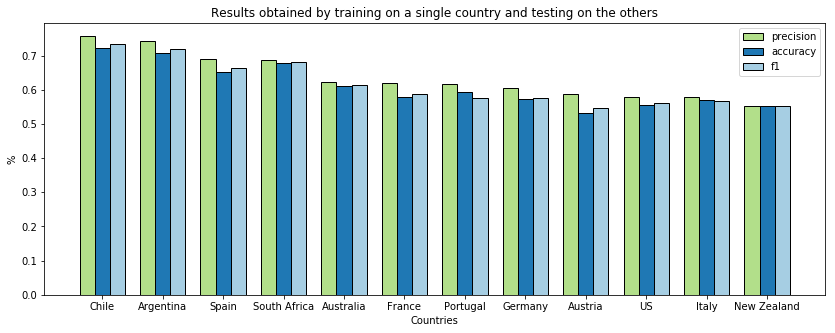

In [51]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results obtained by training on a single country and testing on the others")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


In [ ]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_f1","medium_f1","high_f1"]]
temp = temp.sort_values(["medium_f1","high_f1","low_f1"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_f1"]
# Choose the height of the cyan bars
bars2 = temp["medium_f1"]

bars3 = temp["high_f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("Results (f1) obtained by training on a single country and testing on all the others") 
# Show graphic
plt.show()

In [ ]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = trainedOnSingleCountry.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

In [ ]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [ ]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry": #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# DUMMY (train one country, test others)

In [ ]:
for c in countries:
    X = wine_base
    wine_base["category"] = Y
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train = X[X["country"] == c]
    y_train = list(X_train["category"])
    print(c +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
    print(str(X_train["country"].unique().tolist()) + "country in the training set")
    X_train.drop(["country","category"],axis=1,inplace=True)

    X_test = X[X["country"] != c]
    y_test = X_test["category"]
    print(str(X_test["country"].unique().tolist()) + "country in the test set")
    X_test.drop(["country","category"],axis=1,inplace=True)
   
    classifier = DummyClassifier("stratified")
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print("COUNTRY " + c + classification_report(y_test, y_pred, target_names=labels))


# train on one, test on one

In [24]:
def trainByCountry2(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest2(wine3,el)
        df = df.append(res)
    return df

def applyTest2(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult2(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult2(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth","combination","trainedOn","testedOn"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        countries = data["country"].unique().tolist()
        interestingC =[]
        for gg in countries:
            if gg != objCountry:
                interestingC.append(gg)
      #  countries = countries.remove(objCountry) 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        X_train.drop(["country","category"],axis=1,inplace=True)

        for countr in interestingC:
            X_test = X[X["country"] == countr]
            y_test = X_test["category"]
            X_test.drop(["country","category"],axis=1,inplace=True)
            for depth in combination["depth"]:
                    row = row + 1  
                    #train stuff
                    classifier = DecisionTreeClassifier(max_depth=depth)
                    classifier.fit(X_train,y_train)
                    y_pred = classifier.predict(X_test)  
                    acc = accuracy_score(y_test,y_pred)#average="macro")
                    weightedPrec = precision_score(y_test,y_pred,average="weighted")
                    f1 = f1_score(y_test,y_pred,average="weighted")
                    nations = objCountry +"->"+countr
                    rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth,nations,objCountry,countr]
                    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                    for i in range(0,len(labels)):
                        rowData.append(precision[i])
                        rowData.append(recall[i])
                        rowData.append(fscore[i])
                        rowData.append(support[i])
                        temp = {}
                    c = zip(el,classifier.feature_importances_)
                    names = []
                    for name,importance in c:
                        temp[name] = importance
                        names.append(name)
                    for feat in names:
                        #if feat not in allfeatures:
                         #   rowData.append(100) #100 is an impossible value not to be taken into account
                        #else:
                            rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                    df2 = pd.DataFrame([rowData],columns=cols)
                    results = results.append(df2,ignore_index=True)
            comb = comb + 1
    return results

In [26]:
twoComb = trainByCountry2(wine_base,countries)
twoComb.drop("input",inplace=True,axis=1)
twoComb

C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-package

C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-package

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,combination,trainedOn,testedOn,low_prec,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Argentina,0.585195,0.553080,0.551183,2,Argentina->Italy,Argentina,Italy,0.476900,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,decTree,Argentina,0.566042,0.553257,0.544477,3,Argentina->Italy,Argentina,Italy,0.476900,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,decTree,Argentina,0.562335,0.561922,0.530799,4,Argentina->Italy,Argentina,Italy,0.512601,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,decTree,Argentina,0.565413,0.563985,0.563810,5,Argentina->Italy,Argentina,Italy,0.494245,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,decTree,Argentina,0.576709,0.576186,0.570359,6,Argentina->Italy,Argentina,Italy,0.518178,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,decTree,Argentina,0.586741,0.588889,0.573671,2,Argentina->Portugal,Argentina,Portugal,0.724747,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,decTree,Argentina,0.633862,0.626061,0.620541,3,Argentina->Portugal,Argentina,Portugal,0.724747,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
7,decTree,Argentina,0.563292,0.574141,0.513123,4,Argentina->Portugal,Argentina,Portugal,0.743421,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
8,decTree,Argentina,0.562713,0.579192,0.542565,5,Argentina->Portugal,Argentina,Portugal,0.675134,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9,decTree,Argentina,0.590962,0.598586,0.572783,6,Argentina->Portugal,Argentina,Portugal,0.723684,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [27]:
temp1 = pd.DataFrame()
feats=[]
for f in twoComb.columns:
    if f != "algorithm" and f != "ObjectiveCountry" and f != "depth":
        feats.append(f)
for f in feats:
    temp1[f] = twoComb[f]
temp1 = temp1.groupby("combination")
t2 =pd.DataFrame()
for col in feats:
    if col != "combination" and col != "trainedOn" and col != "testedOn":
        t2[col] = temp1[col].mean()

t2.reset_index(inplace=True)
t2

,combination,precision,accuracy,f1,low_prec,low_recall,low_f1,low_support,medium_prec,medium_recall,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,Argentina->Australia,0.569009,0.562723,0.534997,0.690357,0.523368,0.589397,582,0.560142,0.852284,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Argentina->Austria,0.541810,0.410280,0.418150,0.785167,0.386039,0.515928,1318,0.253941,0.806019,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Argentina->Chile,0.711823,0.732772,0.712158,0.558378,0.565782,0.560818,339,0.804279,0.898632,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Argentina->France,0.552339,0.551158,0.533682,0.666684,0.545433,0.596999,5956,0.591520,0.753591,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Argentina->Germany,0.587077,0.548938,0.551256,0.719518,0.612929,0.661574,758,0.384591,0.725000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Argentina->Italy,0.571139,0.561686,0.552125,0.495765,0.716837,0.583518,4009,0.667672,0.642328,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Argentina->New Zealand,0.523992,0.506309,0.457804,0.621796,0.412451,0.487729,257,0.499918,0.851534,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Argentina->Portugal,0.587514,0.593374,0.564537,0.718347,0.443235,0.548140,1249,0.627964,0.886378,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Argentina->South Africa,0.598742,0.611682,0.586656,0.589160,0.461472,0.516576,231,0.664683,0.869949,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Argentina->Spain,0.647435,0.653929,0.648758,0.609563,0.621838,0.614073,925,0.756823,0.791178,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


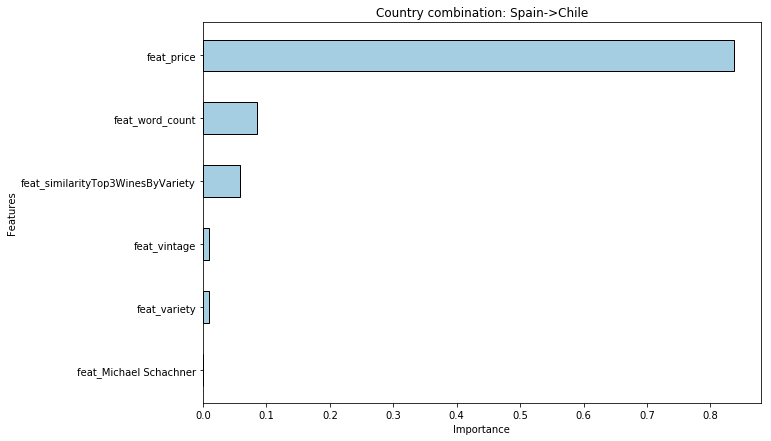

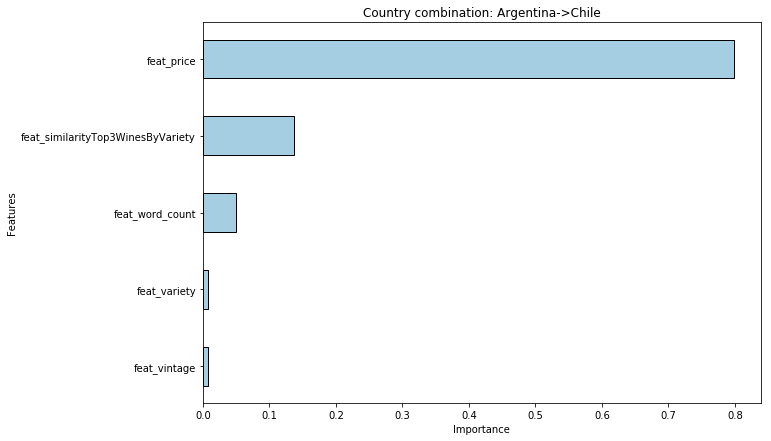

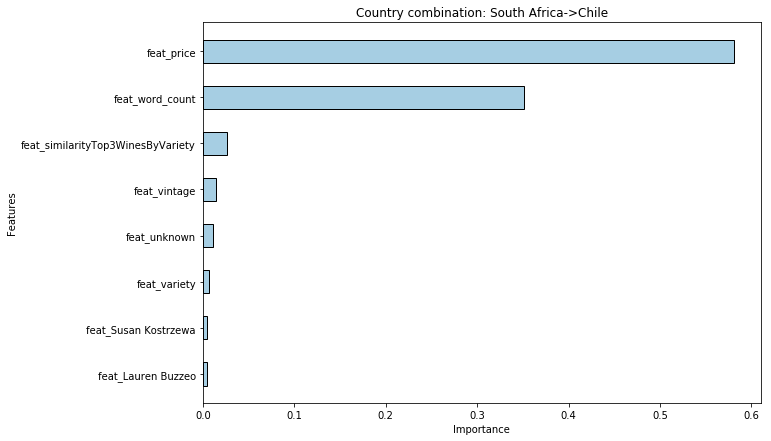

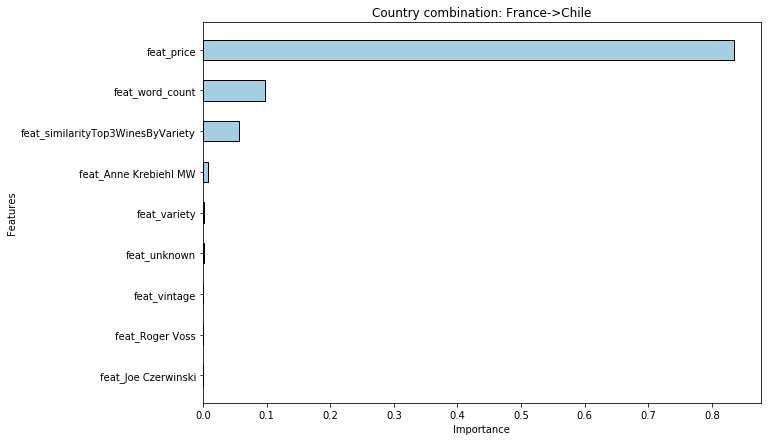

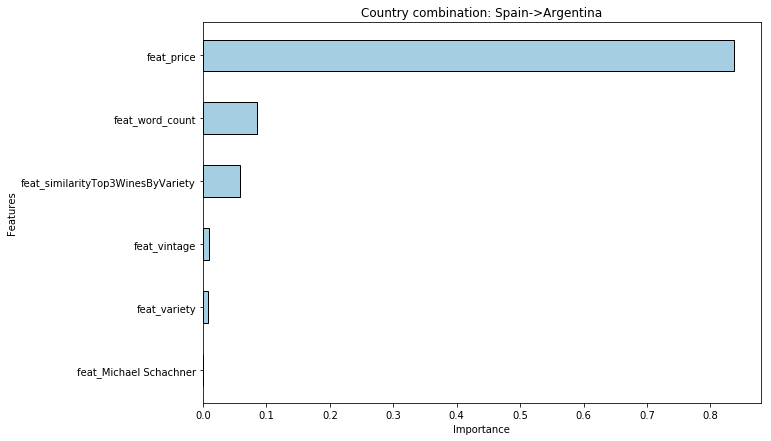

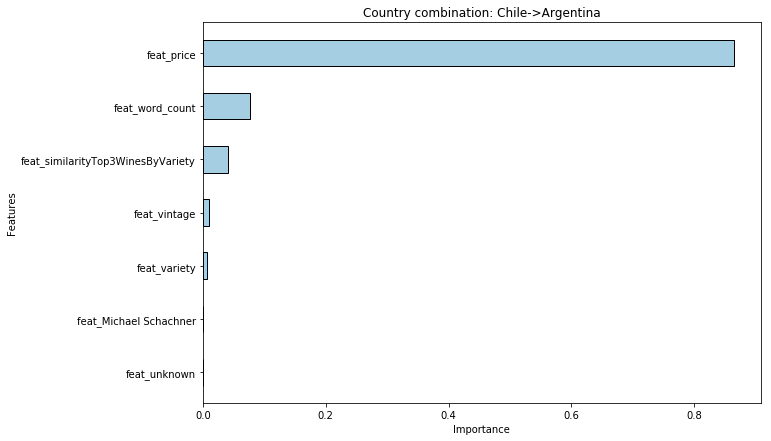

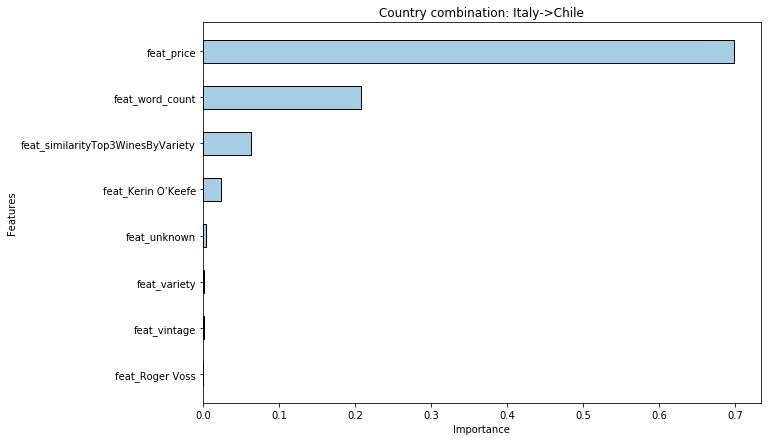

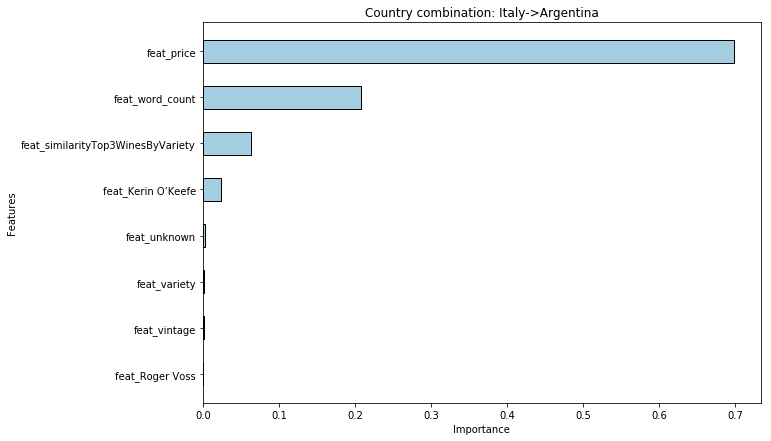

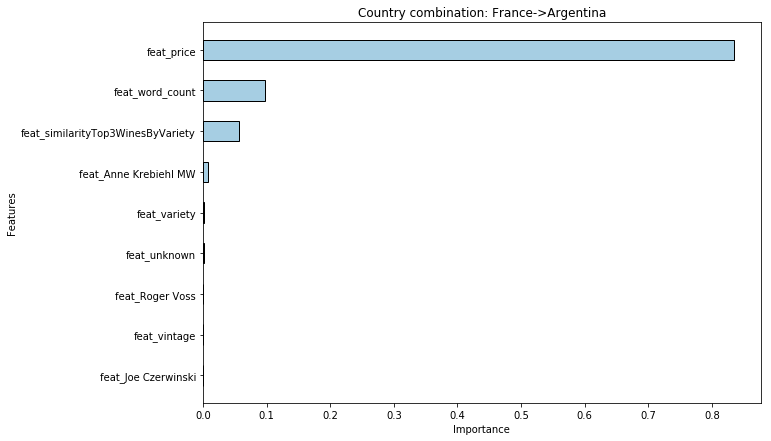

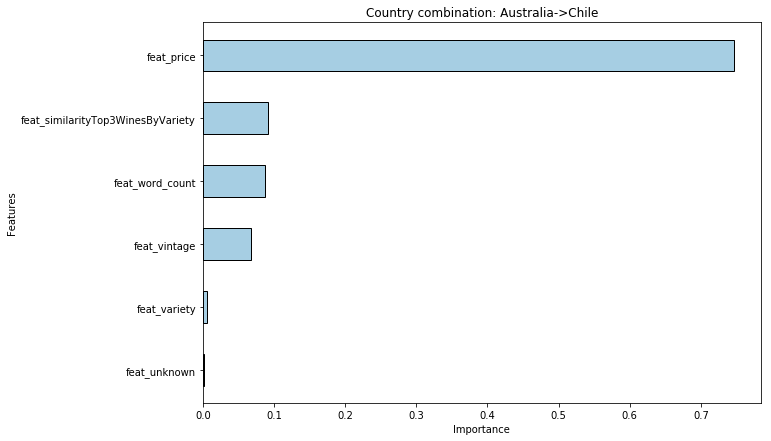

In [28]:
temp = t2
temp = temp.sort_values(["f1"],ascending=False)
temp = temp.head(10)
for idx,row in temp.iterrows():
    both = []
    for col in temp.columns:
        if row[col] != 0 and col != "combination" and col.startswith("feat"): #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Country combination: "+ row["combination"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

(media fra i risultati e li normalizzi) divide every mean obtained on germany by the mean of germany. Look at the average f1 by target country, if it's higher than 64/65, indaga perchè è più alto del 65 ottenuto con 70% train 30% test

# Nation to nation heatmap

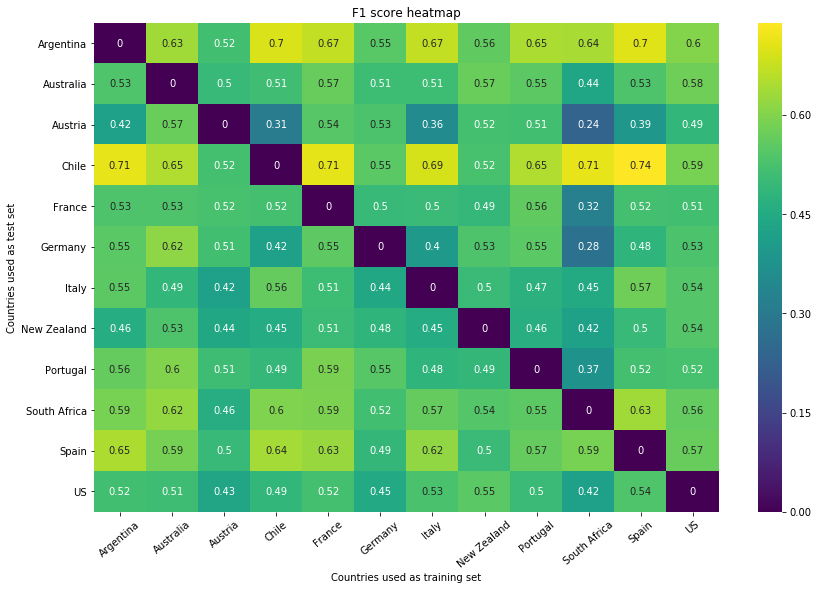

In [29]:
temp1 = pd.DataFrame()
feats=["trainedOn","testedOn","f1"]
for f in feats:
    temp1[f] = twoComb[f]
temp1 = temp1.groupby(["trainedOn","testedOn"])
t2 =pd.DataFrame()
for col in feats:
    if col != "combination" and col != "trainedOn" and col != "testedOn":
        t2[col] = temp1[col].mean()
t2.reset_index(inplace=True)
#t2.sort_values("f1",ascending=False)
columns = ["trainedOn"]
countries = t2["trainedOn"].unique().tolist() #it's also the order
for c in countries:
    columns.append(c)
heatDf = pd.DataFrame(columns = columns)
l = [None] * len(columns)
for trained in countries:
    test = t2[t2["trainedOn"] == trained]
    df2 = pd.DataFrame([l],columns=columns).fillna(0.0)
    df2["trainedOn"] = trained
    for idx,row in test.iterrows():
        df2[row["testedOn"]] = row["f1"]
    heatDf = heatDf.append(df2)
heatDf.reset_index(drop=True,inplace=True)

#plot heatmap
Index= countries
Cols = countries
df = pd.DataFrame(heatDf.drop("trainedOn",axis=1).transpose().values, index=Index, columns=Cols)
fig, ax = plt.subplots(figsize = (14, 9))

sns.heatmap(df, annot=True,cmap="viridis")
plt.title("F1 score heatmap")
plt.ylabel("Countries used as test set")
plt.xlabel("Countries used as training set")
plt.xticks(rotation=40)
plt.show()